# Notebook for experiments and plotting

## typing

In [1]:
from collections.abc import Callable, Generator
from typing_extensions import TypeAlias

from jaxtyping import Array, Float

import optax


Data: TypeAlias = dict[str, Float[Array, "n_samples ..."]]

DataGenerator: TypeAlias = Generator[Data, None, None]

Model: TypeAlias = Callable


## Bachelier Model

In [2]:
from typing import Protocol

import jax.numpy as jnp
from jaxtyping import Array, ArrayLike, Float, ScalarLike


class Payoff(Protocol):
    """TODO: ."""

    @staticmethod
    def call(maturity_prices: Float[ArrayLike, " n"], strike_price: Float[ScalarLike, ""]) -> Float[ArrayLike, " n"]:
        """TODO: ."""
        ...

    @staticmethod
    def put(maturity_prices: Float[ArrayLike, " n"], strike_price: Float[ScalarLike, ""]) -> Float[ArrayLike, " n"]:
        """TODO: ."""
        ...


class EuropeanPayoff:
    """TODO: ."""

    @staticmethod
    def call(maturity_prices: Float[ArrayLike, " n"], strike_prices: Float[ScalarLike, ""]) -> Float[Array, " n"]:
        """TODO: ."""
        return jnp.maximum(jnp.subtract(maturity_prices, strike_prices), 0.0)

    @staticmethod
    def put(maturity_prices: Float[ArrayLike, " n"], strike_prices: Float[ScalarLike, ""]) -> Float[Array, " n"]:
        """TODO: ."""
        return jnp.maximum(jnp.subtract(strike_prices, maturity_prices), 0.0)


In [3]:
from dataclasses import dataclass
from functools import partial
from typing import Final

import jax
import jax.numpy as jnp
import jax.random as jrandom
import jax.scipy.stats as jstats
from jaxtyping import Array, Float, PRNGKeyArray, ScalarLike




def generate_correlation_matrix(key: PRNGKeyArray, n_samples: int) -> Array:
    """TODO: ."""
    data = jrandom.uniform(key, shape=(2 * n_samples, n_samples), minval=-1.0, maxval=1.0)
    covariance = data.T @ data
    inv_vols = jnp.diag(1.0 / jnp.sqrt(jnp.diagonal(covariance)))
    return jnp.linalg.multi_dot([inv_vols, covariance, inv_vols])


class Basket:
    """TODO: ."""


# TODO: seperate the analytic part into a seperate class
# TODO: seperate the basket aspect out of the model
@dataclass
class Bachelier:
    """Bachelier model.

    References:
        https://en.wikipedia.org/wiki/Bachelier_model

        https://iwasawa.us/normal.pdf

    Attributes:
        key: a key for the random number generator of jax.
        n_dims: number of dimensions. A dimension usually corresponds to an asset price.
        weights: an array of weights indicating the importance
            of each dimension of the spots, i.e. the weight of the asset in the basket.
        t_exposure: the start time you get exposed to the option.
        t_maturity: the time the option will expire, i.e. reach its maturity.
        strike_price: the strike price, often refered to as $K$.
        vol_mult: the volatility multiplier. If above 1, more data will be generated on the wings.
        vol_basket: the volatility of the basket. Used to normalize the volatilities.
    """

    key: PRNGKeyArray
    n_dims: Final[int]
    weights: Float[Array, " n_dims"]

    t_exposure: float = 1.0
    t_maturity: float = 2.0
    strike_price: float = 1.10
    vol_mult: float = 1.5
    vol_basket: float = 0.2
    use_antithetic: bool = True

    def __init__(self, key, n_dims, weights):
        """TODO: ."""
        if n_dims != len(weights):
            val = f"Mismatch in number of dimensions ({n_dims}) and number of weights ({weights}) given."
            raise ValueError(val)

        self.key = key
        self.n_dims = n_dims

        # scale weights to sum up to 1
        self.weights = weights / jnp.sum(weights)

    def baskets(self, spots):
        """TODO: ."""
        return jnp.dot(spots, self.weights).reshape((-1, 1))

    @staticmethod
    def path_simulation():
        """TODO: ."""
        pass

    @staticmethod
    def payoff_analytic_differentials(xs, paths, weights, strike_price):
        """TODO: ."""
        spots_end = xs + paths
        baskets_end = jnp.dot(spots_end, weights)
        analytic_differentials = jnp.where(baskets_end > strike_price, 1.0, 0.0)
        analytic_differentials = analytic_differentials.reshape((-1, 1))
        weights = weights.reshape((1, -1))
        # TODO: Replace either with jnp.multiply or jnp.matmul.
        #       Make sure to use the correct one! Here it doesn't
        #       matter since we have (x, 1) but this makes it clearer
        #       what the intention behind this operation is.
        result = analytic_differentials * weights
        return result

    @staticmethod
    def payoff_antithetic_analytic_differentials(xs, paths, weights, strike_price):
        """TODO: ."""
        spots_end_a = xs + paths
        baskets_end_a = jnp.dot(spots_end_a, weights)
        spots_end_b = xs - paths
        baskets_end_b = jnp.dot(spots_end_b, weights)

        differentials_a = jnp.where(baskets_end_a > strike_price, 1.0, 0.0).reshape((-1, 1)) * weights.reshape((1, -1))
        differentials_b = jnp.where(baskets_end_b > strike_price, 1.0, 0.0).reshape((-1, 1)) * weights.reshape((1, -1))
        differentials = 0.5 * (differentials_a + differentials_b)
        return differentials

    @staticmethod
    def payoff(
        xs: Float[Array, "n_samples n_dims"],
        paths: Float[Array, "n_samples n_dims"],
        weights: Float[Array, " n_dims"],
        strike_price: Float[ScalarLike, ""],
    ) -> Float[Array, " n_samples"]:
        """TODO: ."""
        spots_end = xs + paths
        baskets_end = jnp.dot(spots_end, weights)
        pay = EuropeanPayoff.call(baskets_end, strike_price)
        return pay

    @staticmethod
    def antithetic_payoff(
        xs: Float[Array, "n_samples n_dims"],
        paths: Float[Array, "n_samples n_dims"],
        weights: Float[Array, " n_dims"],
        strike_price: Float[ScalarLike, ""],
    ) -> Float[Array, " n_samples"]:
        """TODO: ."""
        spots_end_a = xs + paths
        baskets_end_a = jnp.dot(spots_end_a, weights)
        pay_a = EuropeanPayoff.call(baskets_end_a, strike_price)

        spots_end_b = xs - paths
        baskets_end_b = jnp.dot(spots_end_b, weights)
        pay_b = EuropeanPayoff.call(baskets_end_b, strike_price)

        pay = 0.5 * (pay_a + pay_b)
        return pay
    
    

    def sample(self, n_samples: int) -> Data:
        """TODO: ."""


        #  w.l.o.g., initialize spots, i.e. S_0, as all ones
        spots_0 = jnp.repeat(1.0, self.n_dims)

        # generate random correlation matrix
        # TODO: Do we want external keys for sampling?
        self.key, subkey = jrandom.split(self.key)
        correlated_samples = generate_correlation_matrix(subkey, self.n_dims)

        # TODO: consider using cupy for random number generation in MC simulation
        #       in general we should extract the random number generator to be agnostic

        # generate random volatilities
        self.key, subkey = jrandom.split(self.key)
        vols = jrandom.uniform(subkey, shape=(self.n_dims,), minval=5.0, maxval=50.0)

        # W.l.o.g., normalize the volatilities for a given volatility of the basket.
        # It makes plotting the data more convenient.
        normalized_vols = (self.weights * vols).reshape((-1, 1))
        v = jnp.sqrt(jnp.linalg.multi_dot([normalized_vols.T, correlated_samples, normalized_vols]).reshape(1))
        vols = vols * self.vol_basket / v


        t_delta = self.t_maturity - self.t_exposure



        
        diag_v = jnp.diag(vols)
        cov = jnp.linalg.multi_dot([diag_v, correlated_samples, diag_v])
        self.key, subkey = jrandom.split(self.key)
        
        ### ---- old with cholesky ---- ####
        # Cholesky
        chol = jnp.linalg.cholesky(cov) * jnp.sqrt(t_delta)
        # increase vols for simulation of xs so we have more samples in the wings
        chol_0 = chol * self.vol_mult * jnp.sqrt(self.t_exposure / t_delta)
        # simulations
        normal_samples = jrandom.normal(subkey, shape=(2, n_samples, self.n_dims))
        paths_0 = normal_samples[0] @ chol_0.T
        paths_1 = normal_samples[1] @ chol.T


        #### ---- new: sample directly from correlated distribution ---- ####
        ## TODO find out why this does not work
        #mean = jnp.zeros(self.n_dims)
        #cov_0 = cov * self.t_exposure * self.vol_mult**2  # Used for paths_0
        #cov_1 = cov * t_delta  # Used for paths_1
        #paths_0 = jrandom.multivariate_normal(subkey, mean, cov_0, shape=(n_samples,))
        #paths_1 = jrandom.multivariate_normal(subkey, mean, cov_1, shape=(n_samples,))



        spots_1 = spots_0 + paths_0




        if self.use_antithetic:
            analytic_differentials_fn = Bachelier.payoff_antithetic_analytic_differentials
            payoff_fn = Bachelier.antithetic_payoff
        else:
            analytic_differentials_fn = Bachelier.payoff_analytic_differentials
            payoff_fn = Bachelier.payoff

        differentials_analytic = analytic_differentials_fn(spots_1, paths_1, self.weights, self.strike_price)
        payoff_fn = partial(payoff_fn, weights=self.weights, strike_price=self.strike_price)

        payoffs_vjp, vjp_fn = jax.vjp(payoff_fn, spots_1, paths_1)
        differentials_vjp = vjp_fn(jnp.ones(payoffs_vjp.shape))[0]

        assert jnp.allclose(differentials_analytic, differentials_vjp)  # noqa: S101


        return {
            "x": spots_1,
            "y": payoffs_vjp,
            "dydx": differentials_vjp,
            "paths1": paths_1, 
        }
    




    def dataloader(self):
        """Yields from already computed data."""
        # TODO: Implement
        pass

    def batch_generator(self, n_batch: int):
        """Generates a batch of data on the fly."""
        while True:
            yield self.sample(n_batch)

    def generator(self, n_precompute: int) -> DataGenerator:
        """Generates new data on the fly.

        Note that this generator continues forever. The `n_precompute` parameter is only
        used to control the number of samples that are computed at once. The generator
        will then yield `n_precompute` times before computing the next set of data points.

        Args:
            n_precompute: number of samples to generate at once.

        Yields:
            A Data object.
        """
        while True:
            samples = self.sample(n_precompute)
            keys = samples.keys()
            values = samples.values()

            for i in range(n_precompute):
                ith_sample = (v[i] for v in values)
                sample = dict(zip(keys, ith_sample))
                yield sample




    def analytic(self, n_samples, minval=0.5, maxval=1.5) -> Data:
        """TODO: ."""

        # adjust lower and upper for dimension
        adj = 1 + 0.5 * jnp.sqrt((self.n_dims - 1) * (maxval - minval) / 12)
        adj_lower = 1.0 - (1.0 - minval) * adj
        adj_upper = 1.0 + (maxval - 1.0) * adj

        # draw random spots within range
        self.key, subkey = jrandom.split(self.key)
        spots = jrandom.uniform(subkey, shape=(n_samples, self.n_dims), minval=adj_lower, maxval=adj_upper)
        
        baskets = jnp.dot(spots, self.weights).reshape((-1, 1))
        time_to_maturity = self.t_maturity - self.t_exposure
        
        prices = Bachelier.Call.price(baskets, self.strike_price, self.vol_basket, time_to_maturity)
        prices = prices.reshape((-1,))
        # prices = prices.reshape((-1, 1))

        # in analytical solution we directly compute greeks w.r.t. the basket price
        greeks = Bachelier.Call.greeks(baskets, self.strike_price, self.vol_basket, time_to_maturity)

        # TODO: generalize
        deltas = greeks[0] @ self.weights.reshape((1, -1))
        gammas = greeks[1]
        vegas = greeks[2]

        return {
            "x": spots,
            "y": prices,
            "dydx": deltas,
            "ddyddx": gammas,
            "dydvol": vegas,
            "baskets": baskets

        }




    class Call:
        """Analytic solutions to price and greeks (delta, gamma, vega) of call option on Bachelier."""

        @staticmethod
        def price(spot, strike, vol, t):
            r"""Analytical solution to the undiscounted call option price.

            As in equation (3) of https://arxiv.org/pdf/2104.08686.pdf.

            Args:
                spot: the spot price, also denoted as $S_0$.
                strike: an array of strike prices, also denoted as $K$.
                vol: volatility, also denoted as $\sigma_N$.
                t: time to maturity, also denoted as $T - t$ or $T$.


            Returns:
                TODO
            """
            sqrt_t = jnp.sqrt(t)
            d = (spot - strike) / (vol * sqrt_t)
            normal_cdf_d = jstats.norm.cdf(d)
            normal_pdf_d = jstats.norm.pdf(d)
            price = vol * sqrt_t * (d * normal_cdf_d + normal_pdf_d)
            return price

        @staticmethod
        def delta(spot, strike, vol, t) -> Array:
            r"""Analytical delta.

            The delta is the derivative of the price sensitivity w.r.t. the spot price.

            As in 5.1 of https://arxiv.org/pdf/2104.08686.pdf.

            Args:
                spot: the spot price, also denoted as $S_0$.
                strike: an array of strike prices, also denoted as $K$.
                vol: volatility, also denoted as $\sigma_N$.
                t: time to maturity, also denoted as $T - t$ or $T$.


            Returns:
                TODO
            """
            d = (spot - strike) / (vol * jnp.sqrt(t))
            return jstats.norm.cdf(d)

        @staticmethod
        def gamma(spot, strike, vol, t) -> Array:
            r"""Analytical gamma.

            The gamma is the 2nd-order derivative of the price
            sensitivity w.r.t. the spot price.

            As in 5.1 of https://arxiv.org/pdf/2104.08686.pdf.

            Args:
                spot: the spot price, also denoted as $S_0$.
                strike: an array of strike prices, also denoted as $K$.
                vol: volatility, also denoted as $\sigma_N$.
                t: time to maturity, also denoted as $T - t$ or $T$.


            Returns:
                TODO
            """
            d = (spot - strike) / (vol * jnp.sqrt(t))
            return jstats.norm.pdf(d) / (vol * jnp.sqrt(t))

        @staticmethod
        def vega(spot, strike, vol, t) -> Array:
            r"""Analytical vega.

            The vega is the 2nd-order derivative of the price
            sensitivity w.r.t. the volatility.

            As in 5.1 of https://arxiv.org/pdf/2104.08686.pdf.

            Args:
                spot: an array of spot prices, also denoted as $S_0$.
                strike: an array of strike prices, also denoted as $K$.
                vol: volatility, also denoted as $\sigma_N$.
                t: time to maturity, also denoted as $T - t$ or $T$.


            Returns:
                TODO
            """
            d = (spot - strike) / (vol * jnp.sqrt(t))
            return jnp.sqrt(t) * jstats.norm.pdf(d)

        @staticmethod
        def greeks(spot, strike, vol, t) -> tuple[Array, Array, Array]:
            r"""Greeks.

            As in 5.1 of https://arxiv.org/pdf/2104.08686.pdf.

            Args:
                spot: an array of spot prices, also denoted as $S_0$.
                strike: an array of strike prices, also denoted as $K$.
                vol: volatility, also denoted as $\sigma_N$.
                t: time to maturity, also denoted as $T - t$ or $T$.


            Returns:
                TODO
            """
            call = Bachelier.Call
            deltas = call.delta(spot, strike, vol, t)
            gammas = call.gamma(spot, strike, vol, t)
            vegas = call.vega(spot, strike, vol, t)
            return deltas, gammas, vegas


## NN

modules

In [4]:
from typing import Optional

import equinox as eqx
import jax
from jaxtyping import Array, Float, PRNGKeyArray



class Normalization(eqx.Module):
    """Preprocessing layer to receive normalized input.

    Similar to `Normalization` layer of Keras.
    """

    mean: Float[Array, ""]
    std: Float[Array, ""]

    @jax.named_scope("dml.nn.Normalization")
    def __call__(self, x: Array, *, key: Optional[PRNGKeyArray] = None) -> Array:
        """Normalizes (input) data.

        Args:
            x: Input data.
            key: Random number generator key (not used).

        Returns:
            Normalized input.
        """
        del key
        return (x - self.mean) / self.std


class Denormalization(eqx.Module):
    """Preprocessing layer to denormalize data to original scale."""

    mean: Float[Array, ""]
    std: Float[Array, ""]

    @jax.named_scope("dml.nn.Denormalization")
    def __call__(self, x: Array, *, key: Optional[PRNGKeyArray] = None) -> Array:
        """Denormalizes (output) data.

        Args:
            x: Output data.
            key: Random number generator key (not used).

        Returns:
            Denormalized output.
        """
        del key
        return x * self.std + self.mean


class Normalized(eqx.Module):
    """Preprocessing layer wrapping a model with normalization and denormalization layers."""

    seq: eqx.nn.Sequential

    def __init__(
        self,
        x_normalizer: Normalization,
        model: Model,
        y_denormalizer: Denormalization,
    ):
        """Initialization.

        Args:
            x_normalizer: Normalization layer.
            model: Model.
            y_denormalizer: Denormalization layer.
        """
        self.seq = eqx.nn.Sequential(layers=(x_normalizer, model, y_denormalizer))

    @jax.named_scope("dml.nn.Normalized")
    def __call__(self, x: Array, *, key: Optional[PRNGKeyArray] = None) -> Array:
        """Forward pass."""
        return self.seq(x, key=key)


utils

In [5]:
import jax.numpy as jnp
import equinox as eqx
import jax.nn as jnn
import jax.random as jr
import jax.tree_util as jtu
from jaxtyping import Float, Array, PRNGKeyArray, PyTree
from jax import vmap, hessian



class LossState(eqx.Module):
    losses: Float[Array, "n_losses"] = jnp.ones(3) * 1/3
    lambdas: Float[Array, "n_losses"] = jnp.ones(3) * 1/3
    initial_losses: Float[Array, "n_losses"] = jnp.ones(3) * 1/3
    accum_losses: Float[Array, "n_losses"] = jnp.zeros(3)
    prev_mean_losses: Float[Array, "n_losses"] = jnp.zeros(3)
    current_iter: Float[Array, "n_losses"] = jnp.zeros(3)

    def update_losses(state, new_value: Float[Array, "n_losses"]): # -> LossState:
        return LossState(new_value, state.lambdas, state.initial_losses, state.accum_losses, state.prev_mean_losses, state.current_iter)

    def update_lambdas(state, new_value: Float[Array, "n_losses"]):# -> LossState:
        return LossState(state.losses, new_value, state.initial_losses, state.accum_losses, state.prev_mean_losses,  state.current_iter)
        
    def update_initial_losses(state, new_value: Float[Array, "n_losses"]): # -> LossState:
        return LossState(state.losses, state.lambdas, new_value, state.accum_losses, state.prev_mean_losses,  state.current_iter)
        
    def update_accum_losses(state, new_value: Float[Array, "n_losses"]): # -> LossState:
        return LossState(state.losses, state.lambdas, state.initial_losses, new_value, state.prev_mean_losses,  state.current_iter)
        
    def update_current_iter(state, new_value: Float[Array, "n_losses"]): # -> LossState:
        return LossState(state.losses, state.lambdas, state.initial_losses, state.accum_losses, state.prev_mean_losses,  new_value)

    def update_prev_mean_losses(state, new_value: Float[Array, "n_losses"]): # -> LossState:
        return LossState(state.losses, state.lambdas, state.initial_losses, state.accum_losses, new_value,  state.current_iter)

    def __repr__(self):
        return "LossState"
    




class MakeScalar(eqx.Module):
    model: eqx.Module

    def __call__(self, *args, **kwargs):
        out = self.model(*args, **kwargs)
        return jnp.reshape(out, ())




def is_linear(x):
    return isinstance(x, eqx.nn.Linear)


def get_weights(m: PyTree):
    return [x.weight for x in jtu.tree_leaves(m, is_leaf=is_linear) if is_linear(x)]


def init_model_weights(model, init_fn: jnn.initializers.Initializer, *, key: PRNGKeyArray):
    weights = get_weights(model)
    new_weights = [init_fn(subkey, weight.shape) for weight, subkey in zip(weights, jr.split(key, len(weights)))]
    new_model = eqx.tree_at(get_weights, model, new_weights)
    return new_model


    
def predict(model, xs):
    pred_y, pred_dydx = vmap(eqx.filter_value_and_grad(MakeScalar(model)))(xs)
    pred_ddyddx = vmap(hessian(MakeScalar(model)))(xs)

    return pred_y, pred_dydx, pred_ddyddx


train

In [6]:
from itertools import islice
from tqdm import tqdm

@eqx.filter_jit
def evaluate(model, test_data, n_batch_size, loss_fn):
    """Compute the average loss of the model on the test data."""
    n_elements = test_data["x"].shape[0]
    n = n_elements // n_batch_size

    batched_test_data = jtu.tree_map(lambda x: jnp.reshape(x, (n, n_batch_size, *x.shape[1:])), test_data)
    flattened_data, treedef = jtu.tree_flatten(batched_test_data)

    def batch_eval(data):
        batch = jtu.tree_unflatten(treedef, data)
        return loss_fn(model, batch)

    losses = vmap(batch_eval)(flattened_data)
    avg_loss = jax.lax.associative_scan(jnp.add, losses)[-1] / n
    return avg_loss


@eqx.filter_jit
def train_step(model, loss_fn, optim: optax.GradientTransformation, opt_state: PyTree, batch: Data, loss_state: LossState):
    """Canonical training step for a single batch."""
    (loss_value, aux), grads = eqx.filter_value_and_grad(loss_fn, has_aux=True)(model, batch, loss_state)
    loss_state = aux[0]
    for_debbuging = aux[1]
    updates, opt_state = optim.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value, loss_state, for_debbuging


def metrics_update_element(metrics: dict, key: str, epoch: int, loss: ArrayLike):
    metrics[key] = metrics[key].at[epoch].set(loss)


def train(
    model,
    loss_fn,
    train_data: DataGenerator,
    eval_fn,
    test_data: Optional[Data],
    optim: optax.GradientTransformation,
    n_epochs: int,
    n_batches_per_epoch: int = 64,
) -> PyTree:
    """Canonical training loop."""
    opt_state = optim.init(eqx.filter(model, eqx.is_array))
    train_loss = jnp.zeros(1)
    batch_size = len(next(train_data)["x"])
    metrics = {"train_loss": jnp.zeros(n_epochs), "test_loss": jnp.zeros(n_epochs)}
    loss_state = LossState(jnp.array([0.0, 0.0, 1.0]), jnp.array([1/3, 1/3, 1/3]), jnp.array([0.0, 0.0, 1.0]), jnp.array([0.0, 0.0, 0.0]), jnp.array([0.0, 0.0, 0.0])) 

    pbar = tqdm(range(n_epochs))
    for_debuggings = []
    for epoch in pbar:
        
        for batch in islice(train_data, n_batches_per_epoch):
            model, opt_state, train_loss, loss_state, for_debugging = train_step(model, loss_fn, optim, opt_state, batch, loss_state)
        for_debuggings.append(for_debugging)

        # update loss_state
        loss_state = loss_state.update_prev_mean_losses(loss_state.accum_losses / loss_state.current_iter[0])
        loss_state = loss_state.update_accum_losses(jnp.zeros(len(loss_state.losses)))
        loss_state = loss_state.update_current_iter(jnp.zeros(len(loss_state.losses)))


        metrics_update_element(metrics, "train_loss", epoch, train_loss)
        epoch_stats = f"Epoch: {epoch:3d} | Train: {train_loss:.5f}"

        if test_data:
            test_loss = evaluate(model, test_data, batch_size, eval_fn)
            metrics_update_element(metrics, "test_loss", epoch, test_loss)
            epoch_stats += f" | Test: {test_loss:.5f}"

        pbar.set_description(epoch_stats)

    return model, metrics, for_debuggings


## HVPs and CFD

In [7]:

# HVP for single point and single direction
def hvp(f, x, v):
    return jax.jvp(lambda x_: eqx.filter_grad(f)(x_), (x,), (v,))[1]

# this is a version where we explicitly add a list of boolean values, indicating whether we should compute the hvp for that direction
# TODO isnt this the same as just setting the undesired directions to 0? Then we could just use the normal hvp_batch function
def hvp_cond(f, x, v, eval_hvp):                                   #jnp.zeros(shape=(x.shape[-1],))
    return jax.lax.cond(eval_hvp, lambda _: hvp(f, x, v), lambda _: jnp.zeros_like(v), None)



def hvp_batch(f, inputs, directions):
    """
    Compute Hessian-vector products: H(x_i) @ v_j
    Args:
        f: scalar-valued function f: R^n -> R
        inputs: [num_inputs, input_dim]
        directions: [num_directions, input_dim]
    Returns:
        hvps: [num_inputs, num_directions, input_dim]
    """
    def hvp_fn(x, v):
        return hvp(f, x, v)
    batched = eqx.filter_vmap(eqx.filter_vmap(hvp_fn, in_axes=(0, None)), in_axes=(None, 0))
    return jnp.transpose(batched(inputs, directions), (1, 0, 2))



def hvp_batch_cond(f, inputs, directions, eval_hvp):
    """
    Compute Hessian-vector products: H(x_i) @ v_j ifff eval_hvp[j] == True
    Args:
        f: scalar-valued function f: R^n -> R
        inputs: [num_inputs, input_dim]
        directions: [num_directions, input_dim]
        eval_hvp: [num_directions] boolean array
            if True, compute H(x_i) @ v_j
            if False, return 0
    Returns:
        hvps: [num_inputs, num_directions, input_dim]
            where hvps[i, j] = np.zeros if eval_hvp[j] == False
    """
    def hvp_cond_fn(x, v, eval_hvp):
        return hvp_cond(f, x, v, eval_hvp)
    batched = eqx.filter_vmap(eqx.filter_vmap(hvp_cond_fn, in_axes=(0, None, None)), in_axes=(None, 0, 0))
    return jnp.transpose(batched(inputs, directions, eval_hvp), (1, 0, 2))








# TODO put cfd stuff this somewhere else, separate file?
def cfd_fn(f, h, x, *args):
    
    def cfd_(direction):
      #jax.debug.print("in cfd_ direction.shape: {shape}", shape=direction.shape)
      
      xph = x + h * direction 
      xmh = x - h * direction 
      fd_of_f = (f(xph, *args) - f(xmh, *args)) / (2 * h)

      #jax.debug.print("in cfd_ fd_of_f.shape: {fd}", fd=fd_of_f.shape)
      return fd_of_f
    
    return cfd_




def cfd_cond_fn(f, batch_size):
    def cfd_cond_(direction, eval_hvp):
        return jax.lax.cond(eval_hvp, lambda direction: f(direction), lambda _: jnp.zeros(shape=(batch_size, direction.shape[-1])), direction)
        
    return eqx.filter_vmap(cfd_cond_, in_axes=(0, 0))







## Losses

In [8]:
from enum import Enum

class SobolevLossType(Enum):
    """Types of Sobolev loss to use.

    Attributes:
        ZEROTH_ORDER: Unmodified loss function.
        FIRST_ORDER: Use first-order derivative information.
        SECOND_ORDER_HUTCHINSON: Use second-order hessian-vector products sampled in random directions.
        SECOND_ORDER_PCA: Use second-order hessian-vector products sampled in PCA directions.
    """

    ZEROTH_ORDER = 0
    FIRST_ORDER = 1
    SECOND_ORDER_HUTCHINSON = 2
    SECOND_ORDER_PCA = 3


RegressionLossFn = Callable[..., Float[Array, ""]]






def normalize_vectors(vectors):
    return vectors / jnp.linalg.norm(vectors, axis=1, keepdims=True)

def generate_random_vectors(k, dim, key, normalize=True):
    key, subkey = jax.random.split(key)
    vectors = jax.random.normal(subkey, shape=(k, dim))
    if normalize:
        vectors = normalize_vectors(vectors)
    return vectors



# apply PCA to first-order gradients of predictions
def PCA_of_dydx_directions(dydx, kappa=0.95, normalize=True):
    
    
    dydx_means = jnp.mean(dydx, axis=0)
    tiled_dydx_used_means = jnp.tile(dydx_means, (dydx.shape[0], 1))
    dydx_used_mean_adjusted = dydx - tiled_dydx_used_means
    U, S, VT = jnp.linalg.svd(dydx_used_mean_adjusted, full_matrices=False)
    principal_components = jnp.diag(S) @ VT
    pca_directions = principal_components.T
    #jax.debug.print("principal_components.shape {shape}", shape=principal_components.shape)
    #jax.debug.print("principal_components[0] {pc0}", pc0=principal_components[0])
    #jax.debug.print("")
    #return .0

    if normalize:
        pca_directions = normalize_vectors(pca_directions)


    # select PCs that account for kappa% of variance
    # singular values scaled to represent % of variance explained.
    S_var = S**2 / jnp.sum(S**2)
    eval_dir = (~(jnp.cumsum(S_var) > kappa)).at[0].set(True) # make use that at least the first principal component is always actively used
    k_dir = jnp.sum(eval_dir) # number of principal components used
    
    #jax.debug.print("eval_dir {v}", v=eval_dir)
    #jax.debug.print("")
    #return .0

    return pca_directions, eval_dir, k_dir







def hvp_power_iterated_sketch(f, x, sketch_directions, q):

    # TODO make some plots of the singular spectrum here to find out why power iteration doesnt work???

    Y = hvp_batch(f=f, inputs=x, directions=sketch_directions) # (batch_size, k, dim)
    Y = jnp.mean(Y, axis=0)  # (k, dim)
    for _ in range(q):
        
        ## --- Re-orthogonalize directions ---
        #Y, _ = jnp.linalg.qr(Y.T)  # Y.T: (dim, k)
        #Y = Y.T  # shape back to (k, dim)

        
        Y = hvp_batch(f=f, inputs=x, directions=Y) # (batch_size, k, dim)
        Y = jnp.mean(Y, axis=0)  # (k, dim)
        Y = hvp_batch(f=f, inputs=x, directions=Y) # (batch_size, k, dim)
        Y = jnp.mean(Y, axis=0)  # (k, dim)

    return Y



def get_rand_SVD_directions(f, x, k, key, kappa=0.95, normalize=True):

    # TODO first rand svd experimental implementation
    dim = x.shape[-1]
    sketch_directions = generate_random_vectors(k, dim, key) # (k, dim)

    # Step 1: build sketch Y = H @ sketch_directions
    Y = hvp_batch(f=f, inputs=x, directions=sketch_directions) # (batch_size, k, dim)
    #jax.debug.print("Y.shape {shape}", shape=Y.shape)
    # TODO understand if averaging over batch_size is the correct approach
    Y = jnp.mean(Y, axis=0)  # (k, dim)
    Y = Y.T # (dim, k)
    #jax.debug.print("Y.shape {shape}", shape=Y.shape)
    
    ## power iterated version of step 1
    #Y = hvp_power_iterated_sketch(f=f, x=x, sketch_directions=sketch_directions, q=0) # (k, dim)
    #Y = Y.T # (dim, k)
    
    
    
    # Step 2: orthonormalize Y
    # TODO breaks when k > dim, which I guess makes sense
    Q, _ = jnp.linalg.qr(Y) # (dim, k)  
    #jax.debug.print("Q.shape {shape}", shape=Q.shape)

    # Step 3: each row of B is H @ q_i
    B_rows = hvp_batch(f=f, inputs=x, directions=Q.T) # (batch_size, k, dim)
    #jax.debug.print("B_rows.shape {shape}", shape=B_rows.shape)  
    # TODO understand if averaging over batch_size is the correct approach
    B_rows = jnp.mean(B_rows, axis=0) # (k, dim)
    #jax.debug.print("B_rows.shape {shape}", shape=B_rows.shape)
    B = jnp.stack(B_rows, axis=0) # (k, dim)
    #jax.debug.print("B.shape {shape}", shape=B.shape)

    # Step 4: SVD on B
    U_tilde, S, Vt = jnp.linalg.svd(B, full_matrices=False) # (k, k)
    #jax.debug.print("U_tilde.shape {shape}", shape=U_tilde.shape)



    # Step 5: Lift back U = Q @ U_tilde
    U = Q @ U_tilde  # (dim, k)
    #jax.debug.print("U.shape {shape}", shape=U.shape)
    #jax.debug.print("")

    S_var = S**2 / jnp.sum(S**2)
    eval_dir = (~(jnp.cumsum(S_var) > kappa)).at[0].set(True) # make use that at least the first principal component is always actively used
    k_dir = jnp.sum(eval_dir) # number of principal components used
    
    for_debugging = {
        "S_var": S_var,
        "primary_direction": U.T[0]}


    return U.T, eval_dir, k_dir, for_debugging


# TODO separate first order and second order loss functions?
@jax.named_scope("dml.losses.sobolev")
def sobolev(loss_fn: RegressionLossFn, *, method: SobolevLossType = SobolevLossType.FIRST_ORDER, ref_model) -> RegressionLossFn:
    sobolev_loss_fn = loss_fn

    if method == SobolevLossType.FIRST_ORDER:

        def loss_balance(n_dims: int, weighting: float = 1.0) -> tuple[float, float]:
            lambda_scale = weighting * n_dims
            n_elements = 1.0 + lambda_scale
            alpha = 1.0 / n_elements
            beta = lambda_scale / n_elements
            return alpha, beta

        def sobolev_first_order_loss(model, batch) -> Float[Array, ""]:
            x, y, dydx = batch["x"], batch["y"], batch["dydx"]
            y_pred, dydx_pred = vmap(eqx.filter_value_and_grad(model))(x)

            assert y.shape == y_pred.shape
            assert dydx.shape == dydx_pred.shape

            value_loss = loss_fn(y, y_pred)
            grad_loss = loss_fn(dydx, dydx_pred)

            n_dims = x.shape[-1]
            alpha, beta = loss_balance(n_dims)

            return alpha * value_loss + beta * grad_loss

        sobolev_loss_fn = sobolev_first_order_loss
    elif method == SobolevLossType.SECOND_ORDER_HUTCHINSON:
        raise NotImplementedError
    


    elif method == SobolevLossType.SECOND_ORDER_PCA:
        


        def loss_balance_even() -> tuple[float, float, float]:

            return 1/3, 1/3, 1/3


        def pca_loss_balance(prev_loss_state, new_loss_state, k_dir, n_dims):  
            
            lam = 1
            
            # NOTE: An appropriate eta is crucial for a working second-order method
            eta = (k_dir / n_dims) ** 2
            scale = (1 + lam * n_dims + eta * n_dims * n_dims)
            alpha = 1 / scale
            beta = (lam * n_dims) / scale
            gamma = 1.0 - alpha - beta


           
            use_balance = True
            if use_balance:
                # TODO: The loss weights should be based on the previous _weighted_ losses. The losses themselves don't 
                #       have to be balanced, only after the weighting there should be balance.
                #
                #       Maybe combine: - prev. weighted loss
                #                      - diff between current and prev loss
                #                      - maybe prev. lambdas?
                #  to predict the lambdas needed to make all the _weighted_ losses of the current step equal.


                # loss_weights = current_mean_losses / jnp.sum(current_mean_losses)
                # jax.debug.print("[{}] loss_weights: {}", current_iter, loss_weights)


                n_steps = 16.0
                is_last_step = new_loss_state.current_iter[0] == n_steps


                # NOTE: raw weighting s.t. the losses are equal does not work as it neglects larger losses in favor of smaller losses
                loss_weights = new_loss_state.losses / jnp.sum(new_loss_state.losses)
                loss_balance = 1/3 / loss_weights
                weighted_loss = jnp.multiply(loss_balance, new_loss_state.losses)
                weighting = loss_balance / jnp.sum(loss_balance)
                balancing = jnp.ones(len(new_loss_state.losses)) - loss_weights
                softmax_balancing = jax.nn.softmax(balancing)

                updated_balance_weight = 10
                softmax_balancing = updated_balance_weight * softmax_balancing
                # lambdas = jnp.array([alpha, beta, gamma])
                # lambdas_new_weights = jax.nn.softmax(lambdas + softmax_balancing)
                # jax.debug.print("lambdas new weights: {}", lambdas_new_weights)
                # alpha, beta, gamma = lambdas_new_weights

                new_lambdas = jax.nn.softmax(jnp.multiply(softmax_balancing, new_loss_state.lambdas)) * is_last_step + (1.0 - is_last_step) * new_loss_state.lambdas
                new_loss_state = new_loss_state.update_lambdas(new_lambdas)
                #alpha, beta, gamma = new_lambdas

                alpha, beta, gamma = weighting


            return alpha, beta, gamma, new_loss_state











        def sobolev_second_order_loss(model, batch, prev_loss_state, ref_model=ref_model) -> Float[Array, ""]:

            # unpack dictionary for readability
            x, y, dydx, paths1 = batch["x"], batch["y"], batch["dydx"], batch["paths1"]
            
            # get surrogate prediction, first-order derivative and hessian
            y_pred, dydx_pred = vmap(eqx.filter_value_and_grad(MakeScalar(model)))(x)
            assert y.shape == y_pred.shape
            assert dydx.shape == dydx_pred.shape

            # loss and first-order differntial loss
            value_loss = loss_fn(y, y_pred)
            grad_loss = loss_fn(dydx, dydx_pred)




            
            #### ---- Get Directions for Hessian Probing ---- ####


            # in random directions
            #rand_directions = generate_random_vectors(k=7, dim=x.shape[-1], key=jax.random.key(42))
            
            # apply PCA to first-order gradients dydx_pred
            # alternatively use dydx of reference model or difference: dydx_pred - dydx
            #pca_directions, eval_dir, k_dir = PCA_of_dydx_directions(dydx_pred)
    

            rand_SVD_directions, eval_dir, k_dir, for_debugging = get_rand_SVD_directions(MakeScalar(model), x, k=7, key=jax.random.key(42), kappa=0.95, normalize=True)
            

            #### ---- Second-Order Targets via Finite Differences ---- ####
            

            payoff_fn = partial(ref_model.antithetic_payoff, # TODO make loss function independent of Bachelier, pass payoff_fn
                                weights=ref_model.weights,
                                strike_price=ref_model.strike_price
                                )
            D_payoff_fn = jax.vmap(jax.grad(payoff_fn)) 
            

            # central finite differences derivative
            h = 1e-1
            cfd_of_dpayoff_fn = cfd_fn(D_payoff_fn, h, x, paths1) 


            
            

            directions = rand_SVD_directions
            #directions = pca_directions
            #directions = rand_directions

            # all directions 
            ddpayoff = jax.vmap(cfd_of_dpayoff_fn)(directions) 
            ddpayoff = jnp.transpose(ddpayoff, (1, 0, 2)) # (batch_size, n_directions, n_dims)
            #jax.debug.print("ddpayoff[{i}] {v}", i=0, v=ddpayoff[0])
            #all_zeros = [jnp.all(A == 0) for A in ddpayoff]
            #non_zero_count = jnp.sum(jnp.array(all_zeros) == False)
            #jax.debug.print("non_zero_count: {v} / {total}", v=non_zero_count, total=ddpayoff.shape[0])

            ## conditional directions
            #cfd_of_dpayoff_cond_fn = cfd_cond_fn(cfd_of_dpayoff_fn, batch_size=x.shape[0]) # TODO get rid of the explicit batch size dependency
            #ddpayoff_cond = cfd_of_dpayoff_cond_fn(directions, eval_dir)
            #ddpayoff_cond = jnp.transpose(ddpayoff_cond, (1, 0, 2))
            ##jax.debug.print("ddpayoff_cond[{i}] {v}", i=i, v=ddpayoff_cond[i]) 






            #### ---- Second-Order Predicitons via HVPs ---- ####


            # all directions
            hvps_pred = hvp_batch(f=MakeScalar(model), 
                                         inputs=x, 
                                         directions=directions
                                         ) # (batch_size, n_directions, n_dims)
            
            #jax.debug.print("directions.shape {shape}", shape=directions.shape)
            #jax.debug.print("hvps_pred.shape {shape}", shape=hvps_pred.shape)
            #jax.debug.print("hvps_pred[{i}][0] {v}", i=i, v=hvps_pred[i][0])
            #jax.debug.print("")
            # return .0

            ## conditional directions
            #hvps_cond_pred = hvp_batch_cond(f=MakeScalar(model), 
            #                             inputs=x, 
            #                             directions=directions,
            #                             eval_hvp=eval_dir,
            #                             )
            
            #jax.debug.print("directions.shape {shape}", shape=directions.shape)
            #jax.debug.print("compute_hvp {v}", v=compute_hvp)
            #jax.debug.print("hvps_cond_pred.shape {shape}", shape=hvps_cond_pred.shape)
            #jax.debug.print("hvps_cond_pred[{i}][0] {v}", i=i, v=hvps_cond_pred[i][0])
            #jax.debug.print("")
            #return .0





            #### ---- Loss and Loss Balancing ---- ####


            hessian_loss = loss_fn(ddpayoff, hvps_pred)
            #hessian_loss = loss_fn(ddpayoff_cond, hvps_cond_pred)

            
            losses = jnp.array([value_loss, grad_loss, hessian_loss])
            new_loss_state = LossState(losses, prev_loss_state.lambdas, prev_loss_state.initial_losses, prev_loss_state.accum_losses + losses, prev_loss_state.prev_mean_losses, prev_loss_state.current_iter + 1.0)

            alpha, beta, gamma = loss_balance_even()
            #alpha, beta, gamma, new_loss_state = pca_loss_balance(prev_loss_state, new_loss_state, k_dir, x.shape[-1])
            #jax.debug.print("alpha: {a:.2f}, beta: {b:.2f}, gamma: {c:.2f}", a=alpha, b=beta, c=gamma)
            
            
            loss = alpha * value_loss + beta * grad_loss + gamma * hessian_loss
            
            return (loss, [new_loss_state, for_debugging])
            # TODO also return alpha, beta, gamma for plotting over epochs?

    

        sobolev_loss_fn = sobolev_second_order_loss

    return sobolev_loss_fn






## Data Generation and Model Definition

In [9]:
import pathlib

import equinox as eqx

import jax.numpy as jnp
import jax.random as jrandom
import jax.tree_util as jtu



In [10]:
# Specify model
key = jrandom.key(0)
n_dims: int = 7
n_samples: int = 8 * 1024
key, subkey = jrandom.split(key)
weights = jrandom.uniform(subkey, shape=(n_dims,), minval=1.0, maxval=10.0)
ref_model = Bachelier(key, n_dims, weights)


# Generate data
train_ds = ref_model.sample(n_samples)
test_ds = ref_model.analytic(n_samples)

x_train_mean = jnp.mean(train_ds["x"])
x_train_std = jnp.std(train_ds["x"])
y_train_mean = jnp.mean(train_ds["y"])
y_train_std = jnp.std(train_ds["y"])


In [18]:
def mse(y: Float[Array, " n"], pred_y: Float[Array, " n"]) -> Float[Array, ""]:
    """Mean squared error loss."""
    return jnp.mean((y - pred_y) ** 2)

def rmse(y: Float[Array, " n"], pred_y: Float[Array, " n"]) -> Float[Array, ""]:
    """Root mean squared error loss."""
    return jnp.sqrt(mse(y, pred_y))



def loss_fn(model, batch: Data) -> Float[Array, ""]:
    xs, ys = batch["x"], batch["y"]
    pred_ys = eqx.filter_vmap(model)(xs)
    return mse(ys, pred_ys)


def eval_fn(model, batch: Data) -> Float[Array, ""]:
    return jnp.sqrt(loss_fn(model, batch))



class KeyGen:
    def __init__(self, seed):
        self.key = jrandom.PRNGKey(seed)

    def next(self):
        self.key, subkey = jrandom.split(self.key)
        return subkey


def train_generator(xs, n_samples: int, n_batch_size: int, *, key):
    while True:
        key, subkey = jrandom.split(key)

        def subset_fn(key):
            choice = jrandom.choice(key=key, a=n_samples, shape=(n_batch_size,))

            def subset(x):
                return x[choice]

            return subset

        yield jtu.tree_map(subset_fn(subkey), xs)


#def train_generator(xs, n_samples: int, n_batch_size: int, *, keygen):
#    while True:
#        subkey = keygen.next()
#
#        def subset_fn(key):
#            choice = jrandom.choice(key=key, a=n_samples, shape=(n_batch_size,))
#
#            def subset(x):
#                return x[choice]
#
#            return subset
#
#        yield jtu.tree_map(subset_fn(subkey), xs)


In [20]:
n_epochs = 100
n_batch_size = 256

key, subkey = jrandom.split(key)

#keygen = KeyGen(seed=42)
#train_gen = train_generator(train_ds, n_samples, n_batch_size, keygen=keygen)

train_gen = train_generator(train_ds, n_samples, n_batch_size, key=subkey)


In [21]:
# Specify the surrogate model architecture
key, subkey = jrandom.split(key)
mlp = eqx.nn.MLP(key=subkey, in_size=n_dims, out_size="scalar", width_size=20, depth=3, activation=jax.nn.silu) # jax.nn.silu

key, subkey = jrandom.split(key)
mlp = init_model_weights(mlp, jax.nn.initializers.glorot_normal(), key=subkey)

surrogate = Normalized(
    Normalization(x_train_mean, x_train_std), mlp, Denormalization(y_train_mean, y_train_std)
)

## Train

In [22]:
# Train the surrogate using sobolev loss
optim = optax.adam(learning_rate=1e-3)
sobolev_loss_fn = sobolev(mse, method=SobolevLossType.SECOND_ORDER_PCA, ref_model=ref_model)
surrogate, metrics, for_debuggings = train(
    surrogate, sobolev_loss_fn, train_gen, eval_fn, test_ds, optim, n_epochs=n_epochs)


Epoch:  99 | Train: 0.00217 | Test: 0.00159: 100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


## Plot Results

In [23]:
import matplotlib.pyplot as plt
import datetime


def plot_eval(pred_y, pred_dydx, pred_ddyddx, test_ds):


    baskets = test_ds["baskets"]
    y_test = test_ds["y"]
    dydx_test = test_ds["dydx"]
    gammas = test_ds["ddyddx"]
    
    pred_y = pred_y[:, jnp.newaxis]

    # Create a single figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the first subplot
    axes[0].plot(baskets, pred_y, '.', markersize=1)
    axes[0].plot(baskets, y_test, '.', markersize=1)
    axes[0].legend(['Pred Price', 'True Price'], loc='upper left')
    axes[0].set_title(f"Values \n rmse: {rmse(pred_y, y_test)}")

    # Plot the second subplot
    dydx_idx = 0
    axes[1].plot(baskets, pred_dydx[:, dydx_idx], '.', markersize=1)
    axes[1].plot(baskets, dydx_test[:, dydx_idx], '.', markersize=1)
    axes[1].legend(['Pred Delta', 'True Delta'], loc='upper left')
    axes[1].set_title(f"Differentials\nrmse: {rmse(pred_dydx, dydx_test)}")

    # Calculate and plot gammas in the third subplot
    pred_gammas = jnp.sum(pred_ddyddx, axis=(1, 2))
    axes[2].plot(baskets, pred_gammas, '.', markersize=1, label='Pred')
    axes[2].plot(baskets, gammas, '.', markersize=1, label='True')
    axes[2].legend()
    axes[2].set_title(f"Gammas\nrmse: {rmse(pred_gammas, gammas)}")

    # Adjust the layout and save the figure to a PDF file
    plt.tight_layout()
    #plt.show()
    now = datetime.datetime.now()
    fig.savefig(f'results/eval_ml_{now}.pdf', bbox_inches='tight')


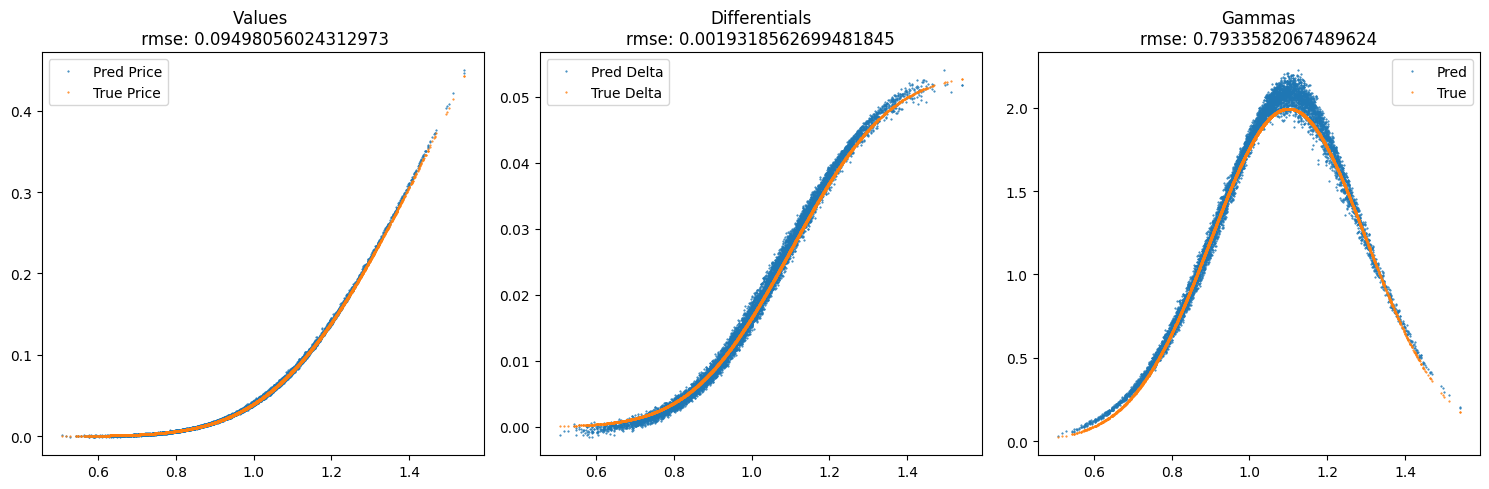

In [24]:
# visualize predictions of model trained on second order data
pred_y, pred_dydx, pred_ddyddx = predict(surrogate, test_ds["x"])
plot_eval(pred_y, pred_dydx, pred_ddyddx, test_ds)

S_var: [4.0224674e-01 2.2915553e-01 2.2035019e-01 1.3058066e-01 1.0452461e-02
 7.1292655e-03 8.5109146e-05]


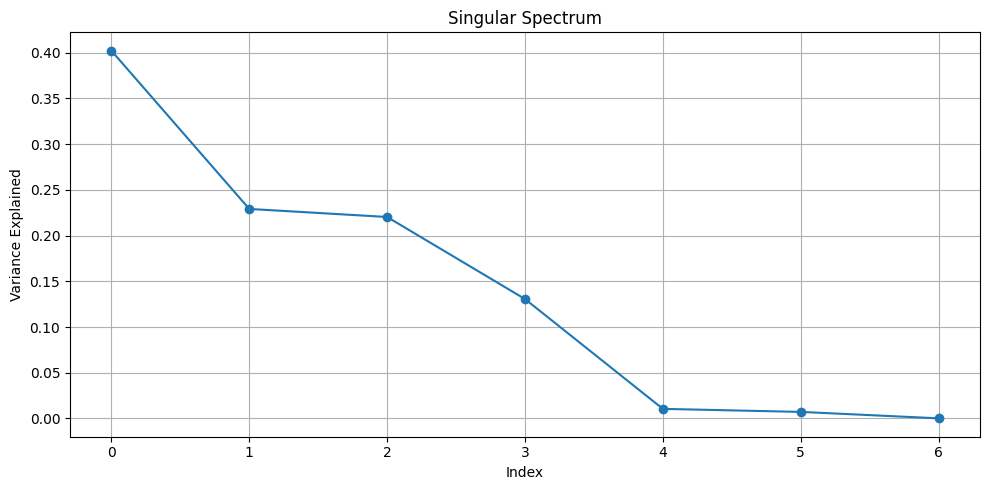

In [17]:
import matplotlib.pyplot as plt

def plot_singular_spectrum(S_var):
    print("S_var:", S_var)
    plt.figure(figsize=(10, 5))
    plt.plot(S_var, marker='o')
    plt.title('Singular Spectrum')
    plt.xlabel('Index')
    plt.ylabel('Variance Explained')
    plt.grid()
    plt.tight_layout()
    plt.show()

epoch = 0
plot_singular_spectrum(for_debuggings[epoch]["S_var"])

In [113]:
for e in range(len(for_debuggings)):
    print(f"Primary direction epoch {e}:", for_debuggings[e]["primary_direction"])

Primary direction epoch 0: [0.12241393 0.135319   0.7012729  0.48577103 0.3484914  0.23901822
 0.24570194]
Primary direction epoch 1: [0.12883928 0.13436683 0.7032391  0.48398232 0.3477807  0.23787434
 0.2429455 ]
Primary direction epoch 2: [0.12229694 0.1322492  0.70537066 0.48641637 0.34701705 0.23525017
 0.2400852 ]
Primary direction epoch 3: [0.12359076 0.13534151 0.6984373  0.4884749  0.3522526  0.23409624
 0.24719034]
Primary direction epoch 4: [0.12187555 0.12923157 0.70866525 0.48146772 0.34474793 0.24132167
 0.23945084]
Primary direction epoch 5: [0.12884106 0.13425103 0.70223045 0.48897836 0.34655687 0.2361543
 0.23932938]
Primary direction epoch 6: [0.12536246 0.13068858 0.7045743  0.4813486  0.34953976 0.23778789
 0.24568272]
Primary direction epoch 7: [0.12119915 0.12568136 0.70399415 0.48562062 0.34572053 0.2402359
 0.24666496]
Primary direction epoch 8: [0.12300799 0.13405997 0.70652336 0.48623124 0.34443176 0.23262158
 0.24198063]
Primary direction epoch 9: [0.12682924 